In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm_notebook
from scipy.io import wavfile
from copy import deepcopy

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
train_data.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [5]:
test_data.head()

,fname,label,usage,freesound_id,license
0,00326aa9.wav,Oboe,Private,355125,Attribution
1,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0
2,007759c4.wav,Saxophone,Private,13406,Creative Commons 0
3,008afd93.wav,Saxophone,Private,358962,Attribution
4,00ae03f6.wav,Chime,Private,78203,Attribution


In [6]:
classes = np.unique(train_data['label'])
n_classes = len(classes)

num_to_label = dict([[v,k] for v,k in enumerate(classes)])
label_to_num = dict([[k,v] for v,k in enumerate(classes)])

with open('./label_to_meta_v1.json','r') as fp:
    label_to_meta = json.load(fp)
    
label_num_to_meta = dict([[label_to_num[f],v] for [f,v] in label_to_meta.items()])

In [7]:
data_manual = train_data[train_data['manually_verified']==1]
data_auto = train_data[train_data['manually_verified']==0]

In [8]:
filenames_all = train_data['fname'].tolist()
meta_labels_all = [label_to_meta[f] for f in train_data['label']]
labels_all = [label_to_num[f] for f in train_data['label']]

filenames_manual = data_manual['fname'].tolist()
meta_labels_manual = [label_to_meta[f] for f in data_manual['label']]
labels_manual = [label_to_num[f] for f in data_manual['label']]

filenames_auto = data_auto['fname'].tolist()
meta_labels_auto = [label_to_meta[f] for f in data_auto['label']]
labels_auto = [label_to_num[f] for f in data_auto['label']]

filenames_test = test_data['fname'].tolist()
meta_labels_test = [label_to_meta[f] for f in test_data['label']]
labels_test = [label_to_num[f] for f in test_data['label']]

In [ ]:
n_meta_classes = len(np.unique(meta_labels_all))

### Load Data

In [9]:
pickle_train = './preprocessed_train/MS-80-HL512-WF16k-64k'
pickle_test = './preprocessed_test/MS-80-HL512-WF16k-64k'

In [10]:
with open(pickle_train,'rb') as fp:
    x_train = pickle.load(fp)
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

In [11]:
sr = 16000
file_length = sr*4
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

In [12]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self,x_set,y_set,
                 batch_size = 128,input_shape = (80,frames),
                 n_classes=80, sr = 44100, seconds = 4):
        
        self.x, self.y = x_set,y_set
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.sr = sr
        self.file_length = sr*seconds
        #self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.x)/self.batch_size))
    
    def __getitem__(self,idx):
        
        spects = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = self.__generate_data(spects)
        
        #print(batch_x.shape)
        #print(batch_y.shape)
        
        return batch_x,batch_y
    
    def __generate_data(self,spects):
        n_mels,frames = self.input_shape
        x_batch = np.zeros((len(spects),n_mels,frames))
        
        for i, spect in enumerate(spects):
            freq_res,time_res = spect.shape
            
            max_start = time_res-frames
            if max_start == 0:
                start = 0
            else:
                start = np.random.randint(0,max_start)
            end = start+frames
            
            x_batch[i] = spect[:,start:end]
        
        return x_batch

Using TensorFlow backend.


# Malley CNN

In [13]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Activation
from keras.layers import GlobalMaxPool2D, Dense, Input
from keras.layers import Lambda
from keras.models import Model
from keras.activations import relu, softmax
from keras.backend import expand_dims
from keras.optimizers import Adam
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

In [14]:
def malley_cnn_80(input_shape, n_meta_classes):

    X_input = Input(input_shape)
    
    X = Lambda(lambda q: expand_dims(q, -1), name='expand_dims') (X_input)
    
    X = Conv2D(64,[3,7],padding = 'same')(X)
    X = Activation(relu)(X)
    X = MaxPool2D([2,1])(X)
    
    X = Conv2D(128,[7,1],padding = 'same')(X)
    X = Activation('relu')(X)
    X = MaxPool2D([4,1])(X)
    
    X = Conv2D(256,[10,1],padding = 'valid')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(512,[1,7],padding = 'same')(X)
    X = Activation('relu')(X)
    
    X = GlobalMaxPool2D()(X)
    
    X = Dense(512,activation = 'relu')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(n_classes, activation = 'softmax')(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [15]:
input_shape = ([n_mels,frames])
lr = 0.001
malley = malley_cnn_80(input_shape,n_classes)
malley.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 125)           0         
_________________________________________________________________
expand_dims (Lambda)         (None, 80, 125, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 125, 64)       1408      
_________________________________________________________________
activation_1 (Activation)    (None, 80, 125, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 125, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 125, 128)      57472     
_________________________________________________________________
activation_2 (Activation)    (None, 40, 125, 128)      0         
__________

In [19]:
malley.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

### Split Dataset and make Generators

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
#X_train_n,X_val_n,y_train_n,y_val_n = train_test_split(X_noisy,y_noisy,test_size=0.1, random_state=7)

In [19]:
X_train_a,X_val_a,y_train_a,y_val_a = train_test_split(x_train,meta_labels_all,test_size=0.1, random_state=7)

In [20]:
#train_generator_n = DataGenerator(X_train_n,y_train_n)
#val_generator_n = DataGenerator(X_val_n,y_val_n)

In [21]:
train_generator_a = DataGenerator(X_train_a,y_train_a)
val_generator_a = DataGenerator(X_val_a,y_val_a)

### Train the Model

In [19]:
malley.fit_generator(train_generator_mc,epochs = 50,validation_data=val_generator_mc)

Epoch 1/50
67/67 [==============================] - 16s 238ms/step - loss: 1.0856 - acc: 0.6113 - val_loss: 0.7940 - val_acc: 0.7331
Epoch 2/50
67/67 [==============================] - 13s 200ms/step - loss: 0.7465 - acc: 0.7334 - val_loss: 0.6878 - val_acc: 0.7500
Epoch 3/50
67/67 [==============================] - 15s 220ms/step - loss: 0.6222 - acc: 0.7797 - val_loss: 0.6317 - val_acc: 0.7711
Epoch 4/50
67/67 [==============================] - 14s 209ms/step - loss: 0.5498 - acc: 0.8097 - val_loss: 0.5539 - val_acc: 0.7996
Epoch 5/50
67/67 [==============================] - 14s 205ms/step - loss: 0.4980 - acc: 0.8302 - val_loss: 0.4888 - val_acc: 0.8323
Epoch 6/50
67/67 [==============================] - 14s 207ms/step - loss: 0.4259 - acc: 0.8540 - val_loss: 0.4644 - val_acc: 0.8302
Epoch 7/50
67/67 [==============================] - 14s 208ms/step - loss: 0.3901 - acc: 0.8640 - val_loss: 0.4332 - val_acc: 0.8376
Epoch 8/50
67/67 [==============================] - 14s 204ms/step - 

In [20]:
malley.load_weights('./weights_test1_malley_mc.h5')

In [21]:
x_test_2 = np.zeros((1600,80,125))

for i, this_x in enumerate(x_test):
    
    this_frames = this_x.shape[1]
    
    if this_frames > 125:
        max_start = this_frames - 125
        start = np.random.randint(0,max_start)
        end = start+125

        this_x = this_x[:,start:end]
        
    x_test_2[i] = this_x

In [22]:
malley.evaluate(x_test_2,meta_labels_test)

1600/1600 [==============================] - 2s 948us/step


[0.4258160419971682, 0.91625]

In [52]:
#malley.save_weights('./weights_test1_malley_mc.h5')

In [23]:
y_scores = malley.predict(x_test_2)

In [24]:
y_hat = np.argmax(y_scores, axis = 1)

In [30]:
y_hat

array([0, 2, 0, ..., 5, 2, 0])

### Plot Confussion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [26]:
cm = confusion_matrix(meta_labels_test,y_hat)

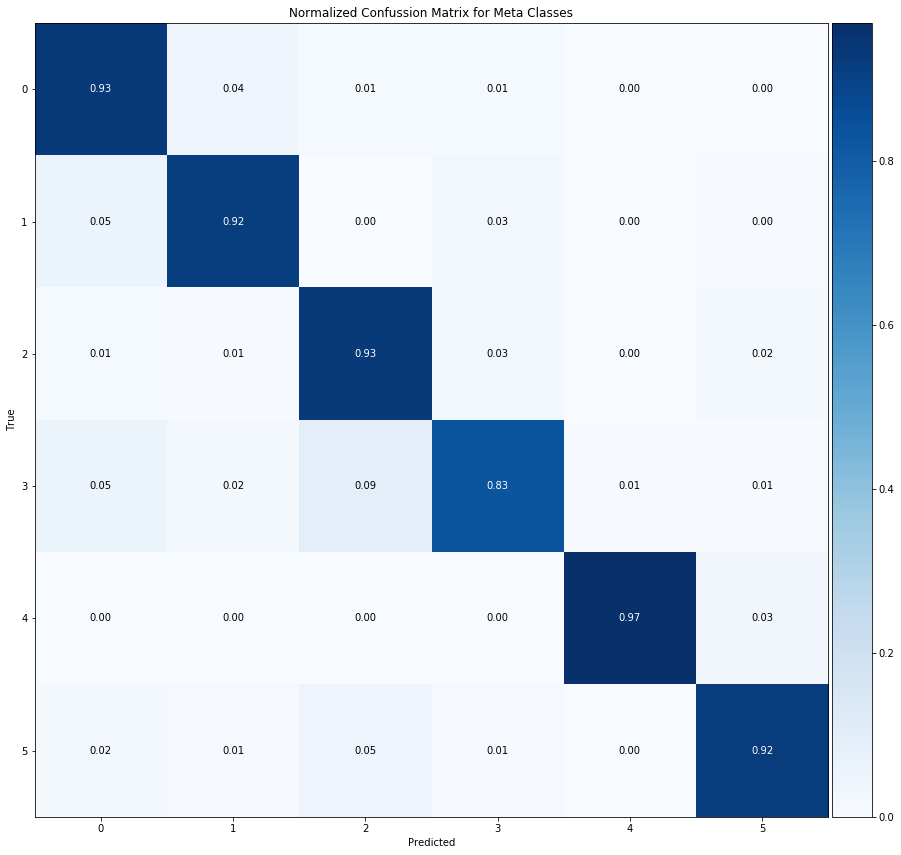

In [38]:
normalize = True


fig, ax = plt.subplots(1,1,figsize = (15,15))
#plt.colorbar(im1,ax = ax)

if normalize:
    ax.set_title('Normalized Confussion Matrix for Meta Classes')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

im1 = ax.imshow(cm, cmap = plt.cm.Blues)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im1, cax=cax)

fig = ax.set(xlabel = 'Predicted', ylabel = 'True')
fig = ax.set_xticks(np.arange(len(np.unique(y_hat))))
#fig = ax.set_xticklabels(c1_to_name.values())

fig = ax.set_yticks(np.arange(len(np.unique(y_hat))))
#fig = ax.set_yticklabels(c1_to_name.values())

fmt = '.2f' if normalize else 'd'

#fmt = 'd'
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

In [51]:
indx_mc_0 = y_hat == 0
indx_mc_1 = y_hat == 1
indx_mc_2 = y_hat == 2
indx_mc_3 = y_hat == 3
indx_mc_4 = y_hat == 4
indx_mc_5 = y_hat == 5

In [ ]:
x_0 = ind

In [48]:
y_hat

array([0, 2, 0, ..., 5, 2, 0])

### Train Only with Curated Data

In [37]:
X_curated = []

for i,tag in enumerate(train_data['manually_verified']):
    if tag == 1:
        X_curated.append(X_all[i])

In [40]:
X_train_c,X_val_c,y_train_c,y_val_c = train_test_split(X_curated,labels_manual,test_size=0.1, random_state=7)

In [41]:
train_generator_c = DataGenerator(X_train_c,y_train_c)
val_generator_c = DataGenerator(X_val_c,y_val_c)

In [49]:
malley.fit_generator(train_generator_c,epochs = 1,validation_data=test_generator)

Epoch 1/1
27/27 [==============================] - 6s 222ms/step - loss: 0.0812 - acc: 0.9721 - val_loss: 1.4502 - val_acc: 0.7562


### Test